In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pandas_summary import DataFrameSummary
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [3]:
challenge  = pd.read_csv(RAW/'Challenge_20180423.csv', low_memory=False)
# customer   = pd.read_csv(RAW/'Customer.csv', low_memory=False)
# isin       = pd.read_csv(RAW/'Isin.csv', low_memory=False)
# submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
trade      = pd.read_csv(RAW/'Trade.csv', low_memory=False)
# market     = pd.read_csv(RAW/'Market.csv', low_memory=False)

In [6]:
trade.head()

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest,IsinBuySell
0,20161207,2789,8478,Sell,653168.0,0.0,Unknown,1.0,8478-Sell
1,20170329,2574,14562,Buy,1656487.0,0.0,Unknown,1.0,14562-Buy
2,20170418,2574,4747,Buy,939673.0,0.0,Unknown,1.0,4747-Buy
3,20170310,2574,9885,Sell,708082.0,0.0,Unknown,1.0,9885-Sell
4,20161116,2574,8885,Buy,1147709.0,0.0,Unknown,1.0,8885-Buy


In [67]:
%%time
trade['IsinBuySell'] = [f'{IsinIdx}-{BuySell}' for IsinIdx, BuySell \
                            in zip(trade.IsinIdx, trade.BuySell)]

CPU times: user 1.57 s, sys: 264 ms, total: 1.84 s
Wall time: 1.83 s


In [19]:
groups = trade.groupby(['CustomerIdx', 'IsinBuySell'], as_index=False)

In [20]:
%%time
ratings = groups['CustomerInterest'].sum()

CPU times: user 1.6 s, sys: 252 ms, total: 1.85 s
Wall time: 1.85 s


In [21]:
ratings.shape

(2046077, 3)

In [22]:
ratings.CustomerInterest.describe()

count    2.046077e+06
mean     1.081059e+00
std      2.986737e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      3.840000e+02
Name: CustomerInterest, dtype: float64

In [23]:
scaling = lambda x: np.log(x+1)

In [24]:
scaling(ratings.CustomerInterest).describe()

count    2.046077e+06
mean     4.650618e-01
std      6.152131e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.931472e-01
max      5.953243e+00
Name: CustomerInterest, dtype: float64

In [25]:
ratings['CustomerInterest'] = scaling(ratings.CustomerInterest)

In [33]:
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate

In [37]:
reader = Reader(rating_scale=(0,6))
data   = Dataset.load_from_df(ratings, reader)

In [39]:
%%time
from surprise import NormalPredictor
baseline = NormalPredictor()
results = cross_validate(baseline, data, cv=5)

CPU times: user 45.3 s, sys: 396 ms, total: 45.7 s
Wall time: 45.7 s


In [41]:
pd.DataFrame(results)

,fit_time,test_mae,test_rmse,test_time
0,1.667338,0.603500,0.796092,3.706553
1,2.341316,0.604363,0.797348,2.790659
2,2.334560,0.603208,0.796364,2.888366
3,2.356088,0.602478,0.795477,3.653400
4,2.335515,0.604627,0.797844,3.726746


In [44]:
%%time
from surprise import NMF
nmf = NMF(n_factors=15, n_epochs=50, biased=True, verbose=True)
results = cross_validate(nmf, data, cv=5, n_jobs=-1)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 0
Processing epoch 4
Processing epoch 1
Processing epoch 5
Processing epoch 2
Processing epoch 6
Processing epoch 3
Processing epoch 0
Processing epoch 7
Processing epoch 4
Processing epoch 1
Processing epoch 8
Processing epoch 5
Processing epoch 2
Processing epoch 9
Processing epoch 6
Processing epoch 3
Processing epoch 0
Processing epoch 10
Processing epoch 7
Processing epoch 4
Processing epoch 1
Processing epoch 11
Processing epoch 8
Processing epoch 5
Processing epoch 2
Processing epoch 12
Processing epoch 9
Processing epoch 6
Processing epoch 3
Processing epoch 13
Processing epoch 7
Processing epoch 10
Processing epoch 0
Processing epoch 4
Processing epoch 11
Processing epoch 8
Processing epoch 14
Processing epoch 1
Processing epoch 5
Processing epoch 12
Processing epoch 9
Processing epoch 15
Processing epoch 2
Processing epoch 6
Processing epoch 10
Processing epoch 13
Processing epoch 16


In [45]:
pd.DataFrame(results)

,fit_time,test_mae,test_rmse,test_time
0,95.318781,0.339437,0.529369,4.620813
1,93.684898,0.331429,0.490118,4.722674
2,91.957144,0.333224,0.498377,4.673400
3,94.045095,0.339584,0.534091,4.571266
4,94.850472,0.343619,0.519864,4.409872


In [46]:
%%time
from surprise import SVD
svd = SVD(n_factors=15, n_epochs=50, biased=True)
results = cross_validate(svd, data, cv=5, n_jobs=-1, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4387  0.4395  0.4396  0.4391  0.4390  0.4392  0.0003  
MAE (testset)     0.2975  0.2982  0.2981  0.2973  0.2971  0.2977  0.0004  
Fit time          69.32   71.21   71.25   70.99   69.08   70.37   0.96    
Test time         4.68    4.63    4.58    4.68    4.40    4.60    0.10    
CPU times: user 30.9 s, sys: 1.68 s, total: 32.5 s
Wall time: 1min 46s


In [47]:
pd.DataFrame(results)

,fit_time,test_mae,test_rmse,test_time
0,69.324018,0.297489,0.438656,4.681322
1,71.205095,0.298158,0.439464,4.627818
2,71.253468,0.298136,0.439600,4.584906
3,70.985030,0.297322,0.439105,4.679991
4,69.079628,0.297145,0.438971,4.402914


## NMF

In [48]:
%%time
from surprise import NMF, Dataset
nmf = NMF(n_factors=15, n_epochs=50, biased=True, verbose=True)
data = Dataset.load_from_df(ratings.sample(frac=1, random_state=42), reader)
trainset = data.build_full_trainset()

CPU times: user 3.74 s, sys: 96 ms, total: 3.83 s
Wall time: 3.83 s


In [49]:
%%time
nmf.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
CPU times:

In [50]:
from tqdm import tqdm_notebook
train_preds = []
for cIdx, iIdx in tqdm_notebook(zip(ratings.CustomerIdx, ratings.IsinBuySell), 
                                total=len(ratings)):
    train_preds.append(nmf.predict(cIdx, iIdx).est)

HBox(children=(IntProgress(value=0, max=2046077), HTML(value='')))

In [53]:
from sklearn.metrics import mean_absolute_error

In [55]:
mean_absolute_error(ratings.CustomerInterest, train_preds)

0.32639371671386647

## SVD

In [56]:
%%time
from surprise import SVD, Dataset
svd = SVD(n_factors=15, n_epochs=50, biased=True, verbose=True)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 48.2 µs


In [57]:
%%time
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
CPU times:

In [58]:
from tqdm import tqdm_notebook
train_preds = []
for cIdx, iIdx in tqdm_notebook(zip(ratings.CustomerIdx, ratings.IsinBuySell), 
                                total=len(ratings)):
    train_preds.append(svd.predict(cIdx, iIdx).est)

HBox(children=(IntProgress(value=0, max=2046077), HTML(value='')))

In [59]:
mean_absolute_error(ratings.CustomerInterest, train_preds)

0.25499927180322934

## Export

In [61]:
from surprise import dump
dump.dump(PROCESSED/'IsinBuySell_svd.dump', algo=svd)
dump.dump(PROCESSED/'IsinBuySell_nmf.dump', algo=nmf)

## Check indices

In [4]:
from src.utils import get_weeks
week_labels = get_weeks(day_from=20160104, num_weeks=121)[52:]

In [5]:
%%time
weeks = []
for name in week_labels:
    weeks.append(pd.read_feather(PROCESSED/f'all_weeks/week_{name}_diffscount.feather'))

CPU times: user 1.65 s, sys: 1.75 s, total: 3.4 s
Wall time: 3.4 s


In [6]:
%%time
for w in weeks:
    w['IsinBuySell'] = [f'{IsinIdx}-{BuySell}' for IsinIdx, BuySell \
                            in zip(w.IsinIdx, w.BuySell)]

CPU times: user 8.08 s, sys: 848 ms, total: 8.93 s
Wall time: 8.93 s


In [8]:
ratingsIsinBuySell = set(ratings.IsinBuySell)
missingIsinBuySell = set()
for n, w in zip(week_labels, weeks):
    print(n, len(set(w.IsinBuySell).difference(ratingsIsinBuySell)))
    missingIsinBuySell = missingIsinBuySell.union(
            set(w.IsinBuySell).difference(ratingsIsinBuySell))

20170102 2
20170109 8
20170116 4
20170123 2
20170130 18
20170206 6
20170213 3
20170220 3
20170227 15
20170306 2
20170313 6
20170320 6
20170327 23
20170403 8
20170410 2
20170417 4
20170424 12
20170501 3
20170508 3
20170515 7
20170522 4
20170529 18
20170605 2
20170612 6
20170619 2
20170626 29
20170703 4
20170710 4
20170717 5
20170724 5
20170731 11
20170807 6
20170814 3
20170821 2
20170828 3
20170904 4
20170911 3
20170918 9
20170925 18
20171002 2
20171009 8
20171016 4
20171023 0
20171030 15
20171106 2
20171113 0
20171120 1
20171127 15
20171204 1
20171211 1
20171218 0
20171225 35
20180101 0
20180108 0
20180115 0
20180122 0
20180129 0
20180205 0
20180212 0
20180219 0
20180226 0
20180305 0
20180312 0
20180319 0
20180326 0
20180402 0
20180409 0
20180416 0
20180423 0


In [9]:
len(missingIsinBuySell)

218

## Fill missing ratings

In [10]:
print(ratings.shape)
ratings.head()

(2888632, 3)


,CustomerIdx,IsinBuySell,CustomerInterest
0,0,16471-Buy,0.693147
1,0,16499-Buy,0.693147
2,0,20601-Buy,0.693147
3,0,20737-Buy,0.693147
4,0,20909-Sell,1.098612


In [94]:
ratings.reset_index(drop=True).to_feather(PROCESSED/'ratings.feather')

In [11]:
extra_ratings = pd.DataFrame([(cIdx, iIdx, 0.0) \
                          for cIdx in ratings.CustomerIdx.unique()
                             for iIdx in missingIsinBuySell],
                            columns=ratings.columns)

In [12]:
extra_ratings.shape

(749702, 3)

In [7]:
ratings = pd.read_feather(PROCESSED/'extra_ratings.feather')

In [14]:
ratings = ratings.append(extra_ratings)

In [15]:
ratings.shape

(3638334, 3)

In [17]:
ratings.reset_index(drop=True).to_feather(PROCESSED/'2017_2018_ratings.feather')

## Retrain NMF

In [19]:
from surprise import Reader
reader = Reader(rating_scale=(0,6))

In [20]:
%%time
from surprise import NMF, Dataset
nmf = NMF(n_factors=15, n_epochs=50, biased=True, verbose=True)
data = Dataset.load_from_df(ratings.sample(frac=1, random_state=42), reader)
trainset = data.build_full_trainset()

CPU times: user 7.41 s, sys: 300 ms, total: 7.71 s
Wall time: 7.7 s


In [21]:
%%time
nmf.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
CPU times:

In [22]:
from tqdm import tqdm_notebook
train_preds = []
for cIdx, iIdx in tqdm_notebook(zip(ratings.CustomerIdx, ratings.IsinBuySell), 
                                total=len(ratings)):
    train_preds.append(nmf.predict(cIdx, iIdx).est)

HBox(children=(IntProgress(value=0, max=3638334), HTML(value='')))

In [24]:
# 2017 + 2018
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ratings.CustomerInterest, train_preds)

0.21913715952821086

In [132]:
# 2018
mean_absolute_error(ratings.CustomerInterest, train_preds)

0.2472032230034846

## Retrain SVD

In [25]:
%%time
from surprise import SVD, Dataset
svd = SVD(n_factors=15, n_epochs=50, biased=True, verbose=True)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 54.6 µs


In [26]:
%%time
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
CPU times:

In [27]:
from tqdm import tqdm_notebook
train_preds = []
for cIdx, iIdx in tqdm_notebook(zip(ratings.CustomerIdx, ratings.IsinBuySell), 
                                total=len(ratings)):
    train_preds.append(svd.predict(cIdx, iIdx).est)

HBox(children=(IntProgress(value=0, max=3638334), HTML(value='')))

In [28]:
mean_absolute_error(ratings.CustomerInterest, train_preds)

0.152488200099937

In [136]:
mean_absolute_error(ratings.CustomerInterest, train_preds)

0.18763633829715243

## Export retrained models

In [29]:
from surprise import dump
dump.dump(PROCESSED/'2017_2018_IsinBuySell_SVD.dump', algo=svd)
dump.dump(PROCESSED/'2017_2018_IsinBuySell_NMF.dump', algo=nmf)

In [138]:
new_ratingsIsinBuySell = set(ratings.IsinBuySell)
for n, w in zip(week_labels, weeks):
    print(n, len(set(w.IsinBuySell).difference(new_ratingsIsinBuySell)))

20180101 0
20180108 0
20180115 0
20180122 0
20180129 0
20180205 0
20180212 0
20180219 0
20180226 0
20180305 0
20180312 0
20180319 0
20180326 0
20180402 0
20180409 0
20180416 0
20180423 0


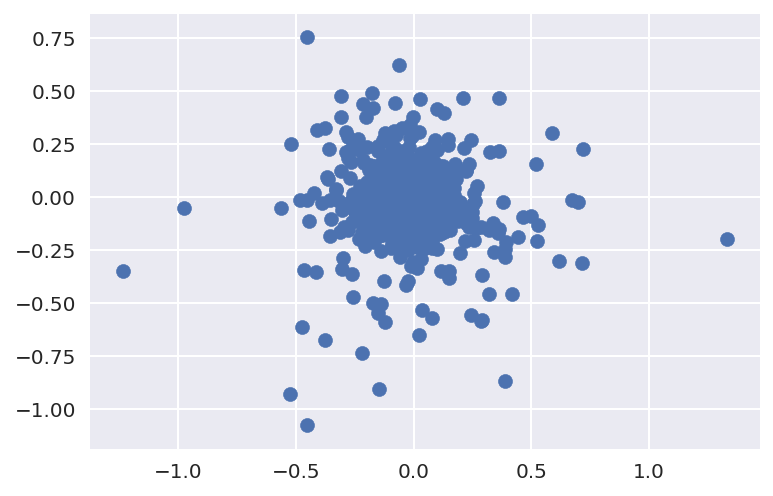

In [139]:
plt.scatter(svd.pu[:,0], svd.pu[:,1])

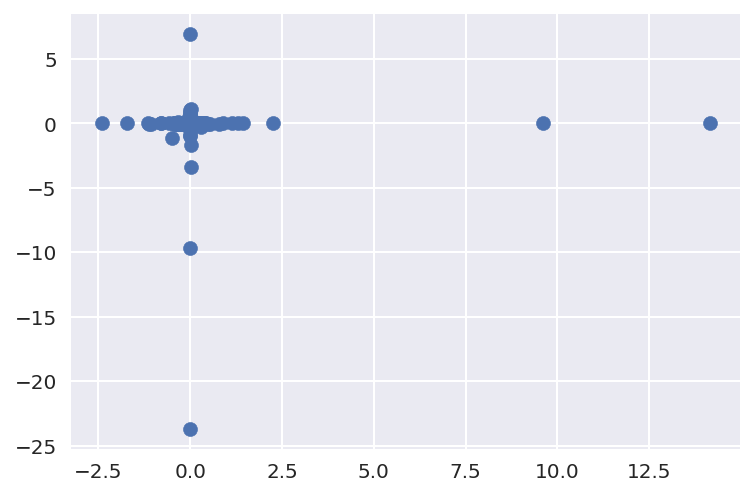

In [140]:
plt.scatter(nmf.pu[:,0], nmf.pu[:,1])